## Data Preprocessing & EDA


Giacomo Grazia

Final Bachelor Project TU/e & TiU

Academic Year 2024-2025

In [1]:
import pandas as pd
import numpy as np
import time
import json
import os
import re
from openai import OpenAI
import locale
from datetime import datetime
import openpyxl
import ast

# Spacy
import spacy
nlp = spacy.load("nl_core_news_lg") # Load spaCy model


import difflib
from IPython.display import display, HTML
from tqdm import tqdm
tqdm.pandas()  # Initialize tqdm with pandas


#pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_colwidth') # to disable run this

# Set the locale to Dutch
locale.setlocale(locale.LC_TIME, "nl_NL.UTF-8")  # Use "nl_NL.UTF-8" for systems with this locale; adjust if needed

'nl_NL.UTF-8'

In [4]:
import os

# Access the OpenAI API key from the environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")

# Use the OpenAI API key
# print(f"OpenAI API Key: {openai_api_key}")

### 1. Loading the Data

In [5]:
df = pd.read_csv('original_data/acm_energy_permit_full.csv')
df = df.drop(columns=['Unnamed: 0', 'retrieval_date_ymd'])
print(df.columns,'\n\n Shape:', df.shape)

Index(['id', 'headline', 'description', 'publication_date', 'decision_date',
       'decision_type', 'case', 'parties', 'file_link', 'text_pypdf2',
       'file_number', 'page_number'],
      dtype='object') 

 Shape: (1964, 12)


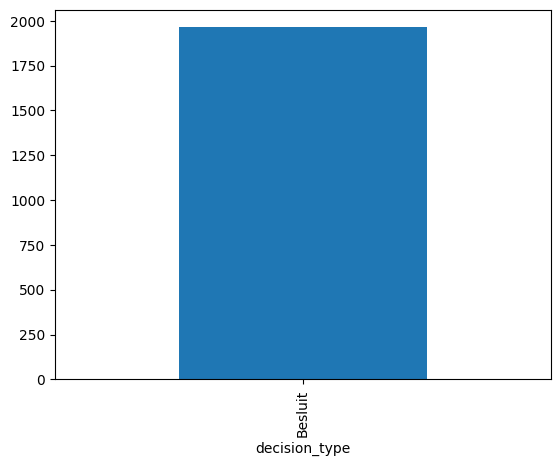

In [6]:
df.decision_type.value_counts().plot(kind='bar');

In [7]:
sum(df.decision_type.isna())
# the column `decision_type` is not meaningful as all rows have the same value. 
df.drop(axis=1, columns='decision_type', inplace=True)

In [8]:
# Proportion of missing values per column
pd.DataFrame(round(df.isna().sum()/len(df), 4)*100, columns=['NaN %'])

,NaN %
id,0.00
headline,0.00
description,0.00
publication_date,0.00
decision_date,14.97
case,9.27
parties,33.15
file_link,0.00
text_pypdf2,2.95
file_number,0.00


### 2. Data Cleaning

##### 2.1 Grouping, inspection, and removal of invalid entries

The following steps were taken to clean the data:

1. Administrative decisions were reconstructed by concatenating text from multiple rows corresponding to the same PDF file. The data for each PDF was distributed across several rows, which shared the same `id` and `file_number`. By merging the text from these rows, each decision was fully reconstructed and represented in a single entry per PDF file.
  
2. In this step, unnecessary formatting elements from the original PDF, such as newline characters, extra spaces, and other artifacts, were removed. This cleaning process ensured that the text was uniform and suitable for further NLP analysis.

In [10]:
# Ensure that the 'text_pypdf2' column is treated as string during concatenation
df_merged = df.groupby(['id', 'file_number'], as_index=False).agg({
    'text_pypdf2': lambda x: ' '.join(x.astype(str)),  # Concatenate all text_pypdf2 values after converting to strings
    'headline': 'first',      # Retain first occurrence for these columns
    'description': 'first',
    'publication_date': 'first',
    'decision_date': 'first',
    'case': 'first',
    'parties': 'first',
    'file_link': 'first'
})

In [11]:
# Unique decision id's, i.e., the number of unique decisions
len(df_merged.id.unique())

309

Corrupted entry removal

In [12]:
# Code to manually check one by one the documents and 
# spot possible formatting issues.

def decision_generator(df):
    for index, text in enumerate(df['text_pypdf2']):
        yield index, text  # Yield both index and text

# Initialize the generator
decisions = decision_generator(df_merged)

def print_next_decision(gen, index):
    try:
        idx, decision = next(gen)  # Unpack the yielded values
        print(f'\nIndex: {idx}')  # Print the row index
        print(decision)            # Print the decision text
        return None        # Return the incremented index
    
    except StopIteration:
        print("No more decisions to review.")
        return index              # Return the same index if no more decisions

In [13]:
# print_next_decision(decisions, i)

In [14]:
# to start over from a higher index
for i in range(143):
    print_next_decision(decisions, i)


Index: 0
 ACM/UIT/606179  
  
Muzenstraat 41  
2511 WB Den Haag  
070 722 20 00  
www.acm.nl  Openbaar  
 
Besluit  
Intrekken  vergunning  gas 
Ons kenmerk  : ACM/UIT/606179  
Zaaknummer  : ACM/23/185948  
Datum  : 13 augustus 2024  
 
Besluit van de Autoriteit Consument en Markt tot het intrekken van de vergunning van TotalEnergies Gas & 
Power Nederland B.V.  voor de levering van gas aan kleinverbruikers.1  
 
1. Aanvraag en Procedure  
1. Op 7 mei 2014 heeft  de Autoriteit Consument en Markt ( hierna: de ACM), namens de Minister van 
Economische Zaken aan Total Gas & Power Nederland B.V  een vergunning verleend2 voor de levering 
van gas aan afnemers die beschikken over een aansluiting op een net met een totale maximale 
capaciteit van ten hoogste 40 m3 (n) per uur (hierna: kleinverbruikers).3 
 
2. In een besluit van de ACM is op 29 september 20214 de leveringsvergunning, die op naam was 
gesteld van  Total Gas & Power Nederland B.V., op naam gezet van TotalEnergies  Power & Gas 

In [15]:
len_before = len(df_merged)

print(f'Entries before cleaning: {len_before}')

# manually investigated the data.
# indices of corrupted docs: 14,185,216-219 (included boundaries)
# indices of nan docs: remaining ones

indices_to_drop = [14, 32, 47, 89, 90, 92, 93] + list(range(96, 99)) + [100, 101, 133, 141, 142, 185, 216] + list(range(217, 220)) + [312, 313]

df_merged = df_merged.drop(indices_to_drop)
df_merged = df_merged.reset_index(drop=True)
unique_ids_after_cleaning = len(df_merged.id.unique())

print(f'Invalid entries (count, percent): {len_before-len(df_merged)}, {((len_before-len(df_merged))/len_before)*100:.2f}%')
print(f'Entries after cleaning: {len(df_merged)}')
print(f'Unique decision id\'s after cleaning: {unique_ids_after_cleaning}')

Entries before cleaning: 381
Invalid entries (count, percent): 22, 5.77%
Entries after cleaning: 359
Unique decision id's after cleaning: 288


##### 2.2 Text cleaning

In [16]:
df_merged['text_pypdf2'] = (
    df_merged['text_pypdf2']
    .str.replace('\n', ' ', regex=False)         # replace newlines with space
    .replace(r'\.{2,}', '', regex=True)          # remove two or more dots, assumed not to be relevant in legal text
    .replace('\t', ' ', regex=False)             # replace tabs with space
    .replace(r'…+', '', regex=True)              # remove ellipsis
    .replace(r'\. \.+', '', regex=True)          # remove dots separated by space (found in entries)
    .replace(r'[^\x00-\x7FÀ-ÿ]', '', regex=True) # keep only ASCII character and accented characters 
                                                 # (e.g. ë which is used in Dutch). Full list of characters printed below.
    .replace(r'\s*\t\s*\t*\s*', '', regex=True)  # pattern found in docs
    .replace(r'\s+([:.,!?;])', r'\1',regex=True) # remove space before punctuation \1 replaces with punc. itself
    
    .replace(r'\s+/', r'/', regex=True)        # remove space before slash
    
    .replace(r'\s+-', '-', regex=True)        # remove space before dash e.g. e -energy
    .replace(r'-\s+', '-', regex=True)        # remove space after dash  e.g. e- energy
    .replace(r'\s+-\s+', '', regex=True)      # remove " - " (space-dash-space) -> design choice, removed
    .replace(r'/\s+', '/', regex=True)        # replace "/ " with "/"
    .replace(r'\s+', ' ', regex=True)         # replace multiple spaces with a single space, always last!
)


df_merged['parties'] = df_merged['parties'].replace(r'\r\n', '', regex=True)


# keep only the text from the first [defined occurence in lamda expression] onwards, including it
# using the 1 in split func. we split only at the first occurrence of "ACM/", not later on.

df_merged['text_pypdf2'] = df_merged['text_pypdf2'].apply(
    lambda x: 'ACM/' + x.split('ACM/', 1)[1] if 'ACM/' in x else x
)
df_merged['text_pypdf2'] = df_merged['text_pypdf2'].apply(
    lambda x: 'AGM/' + x.split('AGM/', 1)[1] if 'AGM/' in x else x
)
df_merged['text_pypdf2'] = df_merged['text_pypdf2'].apply(
    lambda x: 'Ons kenmerk' + x.split('Ons kenmerk', 1)[1] if 'Ons kenmerk' in x else x
)
df_merged['text_pypdf2'] = df_merged['text_pypdf2'].apply(
    lambda x: 'BESLUIT Nummer:' + x.split('BESLUIT Nummer:', 1)[1] if 'BESLUIT Nummer:' in x else x
)


# last step, convert text to lowercase 

df_merged['text_pypdf2'] = df_merged['text_pypdf2'].apply(
    lambda text: text.lower()
)

In [17]:
def print_kept_characters():
    # ASCII range
    ascii_range = [chr(i) for i in range(32, 127)]  # Printable ASCII characters (32 is space, 126 is ~)
    
    # Unicode characters with accents or diaeresis
    accent_range = [chr(i) for i in range(192, 256)]  # From À (192) to ÿ (255)

    print("ASCII characters (32-126):")
    print("".join(ascii_range))
    
    print("\nAccented characters (À-ÿ):")
    print("".join(accent_range))

print_kept_characters()

ASCII characters (32-126):
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~

Accented characters (À-ÿ):
ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ


#### 2.3 Headline, Decision Date, Publication Date, Zaaknummer, Parties

In [18]:
# for safety, remove newlines and extra spaces from the headline
df_merged['headline'] = df_merged['headline'].str.replace('\n', ' ', regex=False).replace(' +', ' ', regex=True)

In [19]:
# convert publication_date and decision_date to datetime objects, 
# with errors='coerce' to leave None for invalid dates
df_merged['publication_date'] = pd.to_datetime(df_merged['publication_date'], 
                                               errors='coerce', 
                                               infer_datetime_format=True)

df_merged['decision_date'] = pd.to_datetime(df_merged['decision_date'],
                                            errors='coerce',
                                            infer_datetime_format=True)

# removing 'Zaaknummer:' from the start of the string in the case column, if present
df_merged['case'] = df_merged['case'].str.replace('^Zaaknummer:', '', regex=True)
df_merged.sample(10)

df_merged.dtypes

/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_12872/2029614425.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_merged['publication_date'] = pd.to_datetime(df_merged['publication_date'],
/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_12872/2029614425.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_merged['publication_date'] = pd.to_datetime(df_merged['publication_date'],
/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_12872/2029614425.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pyd

id                          object
file_number                  int64
text_pypdf2                 object
headline                    object
description                 object
publication_date    datetime64[ns]
decision_date       datetime64[ns]
case                        object
parties                     object
file_link                   object
dtype: object

In [21]:
date_columns = ['publication_date', 'decision_date']
date_ranges = {
    col: {
        'Start Date': df_merged[col].min(),
        'End Date': df_merged[col].max()
    }
    for col in date_columns
}

date_ranges_df = pd.DataFrame(date_ranges).T
date_ranges_df#.to_latex(caption='Date Ranges', label='tab:date-ranges')

,Start Date,End Date
publication_date,2004-06-02,2024-08-27
decision_date,2005-09-29,2024-08-13


In [23]:
# inspecting data to validate that the first publication date is earlier
# than the first decision date due to a missing value in the decision date column
df_merged[df_merged['publication_date'] == '2004-06-02']

,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link
200,id_acm_energy_permit_259,1,dienst uitvoering en toezicht energie b es lu ...,Eneco Energie Retail B.V. mag gas leveren aan ...,Eneco Energie Retail B.V. mag gas leveren aan ...,2004-06-02,NaT,101698-10,Eneco Energie Retail B.V.,https://www.acm.nl/nl/publicaties/publicatie/1...


In [25]:
# some documents may not be addressed to a party
none_percentage = df_merged['parties'].isna().mean() * 100
print(f"Percentage of None values in parties column: {none_percentage:.2f}%")

Percentage of None values in parties column: 33.70%


In [26]:
# check some of the non-addressed parties
none_parties_sample = df_merged[df_merged['parties'].isna()].sample(5)
none_parties_sample

,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link
17,id_acm_energy_permit_111,1,acm/de/2016/206674 zaaknummer: 15.1273.53 besl...,Gemeente Hengelo mag warmte leveren aan verbru...,Gemeente Hengelo mag warmte leveren aan verbru...,2016-11-29,2016-11-14,15.1273.53,None,https://www.acm.nl/nl/publicaties/publicatie/1...
160,id_acm_energy_permit_240,1,besluit nummer: 102548_2/4 betreft zaak: beslu...,Qwint B.V. mag gas leveren aan kleinverbruikers,Qwint B.V. mag gas leveren aan kleinverbruiker...,2013-05-08,2013-04-19,None,None,https://www.acm.nl/nl/publicaties/publicatie/1...
332,id_acm_energy_permit_75,1,ons kenmerk: acm/uit/500183 zaaknummer: acm/18...,EnergieFlex in surseance: intrekking leverings...,De ACM trekt de vergunning van EnergieFlex in....,2018-10-15,NaT,None,None,https://www.acm.nl/nl/publicaties/energieflex-...
319,id_acm_energy_permit_64,1,ons kenmerk: acm/uit/503630 zaaknummer: acm/18...,DNWG Warmte mag warmte leveren aan verbruikers,DNWG Warmte B.V. mag warmte leveren aan verbru...,2018-12-17,2018-11-16,ACM/18/033138,None,https://www.acm.nl/nl/publicaties/dnwg-warmte-...
4,id_acm_energy_permit_10,1,ons kenmerk: acm/uit/618385 zaaknummer: acm/23...,Vergunning elektriciteit Youfone Energie komt ...,De energievergunning van Youfone Energie B.V. ...,2024-04-08,2024-03-27,None,None,https://www.acm.nl/nl/publicaties/vergunning-e...


Statistics of textual columns

In [27]:
text_columns = ['headline', 'description', 'text_pypdf2']
text_stats = {}
rounding = 2

for col in text_columns:
    word_lengths = df_merged[col].dropna().apply(lambda x: len(str(x).split()))
    text_stats[col] = {
        'Average Length': word_lengths.mean().round(rounding),
        'Median Length': word_lengths.median().round(rounding),
        'Standard Deviation': word_lengths.std().round(rounding),
        '25th Percentile': word_lengths.quantile(0.25),
        '75th Percentile': word_lengths.quantile(0.75),
        'Range': (word_lengths.min(), word_lengths.max())
    }

text_stats_df = pd.DataFrame(text_stats, ).T
text_stats_df
# text_stats_df.T.to_latex(caption='Table Caption', 
#                         label='tab:statistics-text-columns', )

,Average Length,Median Length,Standard Deviation,25th Percentile,75th Percentile,Range
headline,8.68,8.0,3.25,6.5,10.0,"(3, 19)"
description,23.0,20.0,7.22,18.0,28.0,"(9, 42)"
text_pypdf2,1632.55,1639.0,1710.47,858.0,1875.5,"(169, 19531)"


### 3. Spelling Correction with OpenAI API

**OpenAI model choice**

When making a text generation request, the first option to configure is which model you want to generate the response. The chosen model can greatly influence the output, and impact how much each generation request costs.

- A large model like **gpt-4o** will offer a very high level of intelligence and strong performance, while having a higher cost per token.
- A small model like **gpt-4o-mini** offers intelligence not quite on the level of the larger model, but is faster and less expensive per token.
- A reasoning model like the **o1 family** of models is slower to return a result, and uses more tokens to "think", but is capable of advanced reasoning, coding, and multi-step planning.

**OpenAI model parameters**
- `temperature`: Set to 0 for consistency in output.
- `response_format`: Enforces JSON output with `corrected_text` only.

#### 3.1 Prompt (a)

In [ ]:
# Helper function to split text into chunks
def split_text(text, max_length=1000):
    """Splits text into smaller chunks with a maximum length."""
    return [text[i:i+max_length] for i in range(0, len(text), max_length)]

# Function to correct spelling using the ChatGPT API with error handling
def correct_spelling(text: str, index: int) -> str:
    """
    Corrects spelling errors in a given Dutch text using the ChatGPT API.
    If token limit error is raised, splits text into chunks and processes them sequentially.

    :param text: The input text in Dutch that needs spelling correction.
    :param index: The index of the row for tracking errors.
    :return: the corrected text with spelling errors fixed. If an error occurs, the original text is returned.
    """
    
    prompt_spelfouten = f"""
    Corrigeer uitsluitend de spelfouten in deze Nederlandse tekst: {text} 
    Behoud de oorspronkelijke structuur, inhoud, en opmaak. Geef alleen de gecorrigeerde tekst terug 
    in de text_pypdf2_gpt-veld van de JSON-output. Er mag geen extra tekst voor of na de JSON-output staan. 
    Alleen het gegeven JSON schema is toegestaan.
    """
    model = "gpt-4o-mini"    
    
    try:
        response = OpenAI(api_key=OPENAI_API_KEY).chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": prompt_spelfouten
                }
            ],
            temperature=0,
            max_tokens=16383,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            response_format={
                "type": "json_schema",
                "json_schema": {
                "name": "text_pypdf2_gpt",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                    "corrected_text": {
                        "type": "string",
                        "description": "The text after correcting typos from the original input."
                    }
                    },
                    "required": [
                    "corrected_text"
                    ],
                    "additionalProperties": False
                    }  
                }
            }
        )
        
        # Extract the JSON content from the response
        result = response.choices[0].message.content
        return result
    
    except Exception as e:
        # Check if the error is due to rate limit (429) and specifically token limit
        if "rate_limit_exceeded" in str(e) and "TPM" in str(e):
            print(f"Token limit exceeded at row {index}. Splitting text into chunks...")
            corrected_chunks = []
            for chunk in split_text(text, max_length=15000): # 15k tokens per chunk
                # Retry for each chunk
                try:
                    corrected_chunk = correct_spelling(chunk, index)  # Recursive call on smaller chunks
                    corrected_chunks.append(corrected_chunk)
                except Exception as inner_e:
                    print(f"Error correcting a chunk at row {index}: {inner_e}")
                    corrected_chunks.append(chunk)  # Append the original chunk if error persists
                    time.sleep(30)  # Pause to avoid hitting the rate limit repeatedly (30k per min)

            # Join all corrected chunks back together
            return ' '.join(corrected_chunks)
        else:
            print(f"Error correcting text at row {index}: {e}")
            return text  # Return the original text if another error occurs


# Apply the function to the DataFrame
df_merged['corrected_text_4omini_prompt_1'] = df_merged.progress_apply(lambda row: correct_spelling(row['text_pypdf2'], row.name), axis=1)

In [ ]:
# save results to a new csv file
# df_merged.to_csv('df_merged_FULL_corrected_spelling_last.csv', index = False)

In [ ]:
df_merged = pd.read_csv('df_merged_FULL_corrected_spelling_last.csv')

In [ ]:
import matplotlib.pyplot as plt

# Calculate Levenshtein distance for each entry
from Levenshtein import distance
df_merged['edit_distance_corrected_text_4omini_prompt_1'] = df_merged.apply(lambda row: distance(row['text_pypdf2'], row['corrected_text_4omini_prompt_1']), axis=1)

# Analyze median distance
median_distance = df_merged['edit_distance_corrected_text_4omini_prompt_1'].median()
print(f"Median edit distance: {median_distance:.3f}")

# Plot the distribution of Levenshtein distances
plt.figure(figsize=(8, 6))
plt.hist(
    df_merged['edit_distance_corrected_text_4omini_prompt_1'], 
    bins=50,  # Reduce bins for a simpler look
    edgecolor='black', 
    color='lightblue', 
    log=True,
)
plt.title('Distribution of Levenshtein Distances', fontsize=18)
plt.xlabel('Levenshtein Distance', fontsize=16)
plt.ylabel('Frequency (Log Scale)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the Y-axis
plt.tight_layout()
plt.savefig('/Users/giacomograzia/Downloads/levenshtein_distance_distribution.png', dpi=300)
plt.show()

In [ ]:
def visualize_differences(original: str, corrected: str) -> str:
    """
    Generates an HTML visualization of the differences between the original and corrected text.
    Highlights removed words in red with strikethrough, added words in green and bold, 
    and leaves unchanged words as normal text.

    :param original: The original text before correction.
    :param corrected: The corrected text after applying spelling adjustments.
    :return: A string containing HTML-formatted differences between the original and corrected text.
    """
    # Use difflib to get the differences
    diff = difflib.ndiff(original.split(), corrected.split())
    
    # Create a list to hold HTML formatted differences
    html_diff = []
    
    for word in diff:
        if word.startswith(' '):  # No change
            html_diff.append(f'<span>{word[2:]}</span>')
        elif word.startswith('-'):  # Removed word
            html_diff.append(f'<span style="color: red; text-decoration: line-through;">{word[2:]}</span>')
        elif word.startswith('+'):  # Added word
            html_diff.append(f'<span style="color: green; font-weight: bold;">{word[2:]}</span>')
    
    # Join the list into a single HTML string
    return ' '.join(html_diff)

# Sort DataFrame by edit distance in descending order
df_sorted = df_merged.sort_values(by='edit_distance_corrected_text_4omini_prompt_1', ascending=False).head(10)

# Loop through the top 10 rows with the highest edit distance
for _, row in df_sorted.iterrows():
    index = row.name  # Get the index of the row
    edit_distance = row['edit_distance_corrected_text_4omini_prompt_1']
    original_text = row['text_pypdf2']
    corrected_text = row['corrected_text_4omini_prompt_1']
    
    # Prepare HTML output with index and edit distance, wrapped in a toggle button
    html_output = f"""
    <details style='margin-top: 20px;'>
        <summary><strong>Index: {index} | Edit Distance: {edit_distance}</strong></summary>
        <div style='margin-top: 10px;'>{visualize_differences(original_text, corrected_text)}</div>
    </details>
    """
    
    # Display the HTML output
    display(HTML(html_output))

#### 3.2 Prompt (b)

In [ ]:
# Helper function to split text into chunks
def split_text(text, max_length=1000):
    """Splits text into smaller chunks with a maximum length."""
    return [text[i:i+max_length] for i in range(0, len(text), max_length)]

# Function to correct spelling using the ChatGPT API with error handling
def correct_spelling(text: str, index: int) -> str:
    """
    Corrects spelling errors in a given Dutch text using the ChatGPT API.
    If token limit error is raised, splits text into chunks and processes them sequentially.

    :param text: The input text in Dutch that needs spelling correction.
    :param index: The index of the row for tracking errors.
    :return: the corrected text with spelling errors fixed. If an error occurs, the original text is returned.
    """
    
    prompt_spelfouten = f"""
    Corrigeer alleen spelfouten in deze Nederlandse tekst: {text} 

    Behoud strikt de oorspronkelijke structuur, inhoud en opmaak. De API mag maximaal één woord per keer aanpassen of samengestelde woorddelen (bijv. "au to" naar "auto") corrigeren.
    Geef uitsluitend de gecorrigeerde tekst terug in het veld text_pypdf2_gpt van de JSON-output. Er mag geen extra tekst voor of na de JSON-output staan, en alleen het gegeven JSON-schema is toegestaan.
    Corrigeer geen stijl, grammatica of formulering, alleen spelling.
    """
    model = "gpt-4o-mini"    
    
    try:
        response = OpenAI(api_key=OPENAI_API_KEY).chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": prompt_spelfouten
                }
            ],
            temperature=0,
            max_tokens=16383,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            response_format={
                "type": "json_schema",
                "json_schema": {
                "name": "text_pypdf2_gpt",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                    "corrected_text": {
                        "type": "string",
                        "description": "The text after correcting typos from the original input."
                    }
                    },
                    "required": [
                    "corrected_text"
                    ],
                    "additionalProperties": False
                    }  
                }
            }
        )
        
        # Extract the JSON content from the response
        result = response.choices[0].message.content
        return result
    
    except Exception as e:
        # Check if the error is due to rate limit (429) and specifically token limit
        if "rate_limit_exceeded" in str(e) and "TPM" in str(e):
            print(f"Token limit exceeded at row {index}. Splitting text into chunks...")
            corrected_chunks = []
            for chunk in split_text(text, max_length=15000): # 15k tokens per chunk
                # Retry for each chunk
                try:
                    corrected_chunk = correct_spelling(chunk, index)  # Recursive call on smaller chunks
                    corrected_chunks.append(corrected_chunk)
                except Exception as inner_e:
                    print(f"Error correcting a chunk at row {index}: {inner_e}")
                    corrected_chunks.append(chunk)  # Append the original chunk if error persists
                    time.sleep(30)  # Pause to avoid hitting the rate limit repeatedly (30k per min)

            # Join all corrected chunks back together
            return ' '.join(corrected_chunks)
        else:
            print(f"Error correcting text at row {index}: {e}")
            return text  # Return the original text if another error occurs

In [ ]:
# Apply the function to the DataFrame
df_merged['corrected_text_4omini_prompt_2'] = df_merged.progress_apply(lambda row: correct_spelling(row['text_pypdf2'], row.name), axis=1)

In [ ]:
import matplotlib.pyplot as plt

# Calculate Levenshtein distance for each entry
from Levenshtein import distance
df_merged['edit_distance_corrected_text_4omini_prompt_2'] = df_merged.apply(lambda row: distance(row['text_pypdf2'], row['corrected_text_4omini_prompt_2']), axis=1)

# Analyze median distance
median_distance = df_merged['edit_distance_corrected_text_4omini_prompt_2'].median()
print(f"Median edit distance: {median_distance:.3f}")

# Plot the distribution of Levenshtein distances
plt.figure(figsize=(8, 6))
plt.hist(
    df_merged['edit_distance_corrected_text_4omini_prompt_2'], 
    bins=50,  # Reduce bins for a simpler look
    edgecolor='black', 
    color='lightblue', 
    log=True,
)
plt.title('Distribution of Levenshtein Distances', fontsize=18)
plt.xlabel('Levenshtein Distance', fontsize=16)
plt.ylabel('Frequency (Log Scale)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the Y-axis
plt.tight_layout()
plt.savefig('/Users/giacomograzia/Downloads/levenshtein_distance_distribution_prompt2.png', dpi=300)
plt.show()

In [ ]:
# save results to a new csv file
df_merged.to_csv('df_merged_FULL_corrected_spelling_last_v2.csv', index = False)


In [ ]:
def visualize_differences(original: str, corrected: str) -> str:
    """
    Generates an HTML visualization of the differences between the original and corrected text.
    Highlights removed words in red with strikethrough, added words in green and bold, 
    and leaves unchanged words as normal text.

    :param original: The original text before correction.
    :param corrected: The corrected text after applying spelling adjustments.
    :return: A string containing HTML-formatted differences between the original and corrected text.
    """
    # Use difflib to get the differences
    diff = difflib.ndiff(original.split(), corrected.split())
    
    # Create a list to hold HTML formatted differences
    html_diff = []
    
    for word in diff:
        if word.startswith(' '):  # No change
            html_diff.append(f'<span>{word[2:]}</span>')
        elif word.startswith('-'):  # Removed word
            html_diff.append(f'<span style="color: red; text-decoration: line-through;">{word[2:]}</span>')
        elif word.startswith('+'):  # Added word
            html_diff.append(f'<span style="color: green; font-weight: bold;">{word[2:]}</span>')
    
    # Join the list into a single HTML string
    return ' '.join(html_diff)

# Sort DataFrame by edit distance in descending order
df_sorted = df_merged.sort_values(by='edit_distance_corrected_text_4omini_prompt_2', ascending=False).head(10)

# Loop through the top 10 rows with the highest edit distance
for _, row in df_sorted.iterrows():
    index = row.name  # Get the index of the row
    edit_distance = row['edit_distance_corrected_text_4omini_prompt_2']
    original_text = row['text_pypdf2']
    corrected_text = row['corrected_text_4omini_prompt_2']
    
    # Prepare HTML output with index and edit distance, wrapped in a toggle button
    html_output = f"""
    <details style='margin-top: 20px;'>
        <summary><strong>Index: {index} | Edit Distance: {edit_distance}</strong></summary>
        <div style='margin-top: 10px;'>{visualize_differences(original_text, corrected_text)}</div>
    </details>
    """
    
    # Display the HTML output
    display(HTML(html_output))
